In [39]:
import ee

ee.Authenticate()
ee.Initialize(project="uav-route-planning")
import geemap
import numpy as np
from skimage.segmentation import flood_fill

"""Class detecting edges in images using different bands from Sentinel2"""


class EdgeDetector:

    def __init__(self, time_periods: list, points: list[ee.Geometry.Point]):
        self.__time_periods = time_periods
        self.__points = ee.FeatureCollection([ee.Feature(point) for point in points])
        self.__map_center = self.__points.geometry().centroid()
        self.__cloud_filter_threshold = 5

    # Finding selected band in a selected place
    def _get_band_image(self, band: str, time_period: list) -> ee.Image:
        """ Function that finds particular band for selected image """
        return (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                .filterDate(time_period[0], time_period[1])
                .filterBounds(self.__map_center)
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', self.__cloud_filter_threshold))
                .select(band)
                .mean())

    # Clouds masking is used only for comparison and visualization
    # TODO: change this function
    def __mask_s2_clouds(self, image: ee.Image) -> ee.Image:
        """Masks clouds in a Sentinel-2 image using the QA band.

        Args:
            image (ee.Image): A Sentinel-2 image.

        Returns:
            ee.Image: A cloud-masked Sentinel-2 image.
        """
        qa = image.select('QA60')

        # Bits 10 and 11 are clouds and cirrus, respectively.
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11

        # Both flags should be set to zero, indicating clear conditions.
        mask = (
            qa.bitwiseAnd(cloud_bit_mask)
            .eq(0)
            .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
        )

        return image.updateMask(mask).divide(10000)

    def _get_RGB_map(self) -> ee.Image:
        """ Function that returns map image for a GEE Map """
        return (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                .filterDate(self.__time_periods[0][0], self.__time_periods[-1][0])
                .filterBounds(self.__map_center)
                # Pre-filter to get less cloudy granules.
                .filter(
            ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', self.__cloud_filter_threshold)
        )
                .map(self.__mask_s2_clouds)
                .mean())

    def _run_canny_for_bands(self, thresholds: list, sigmas: list,
                            bands_data: list, distance: int) -> ee.Image:
        """ Function runs Canny edge detection algorithm for every provided band """
        bands_after_canny = []
        for i in range(len(bands_data)):
            low_threshold_detection = (
                ee.Algorithms.CannyEdgeDetector(
                    image=bands_data[i], threshold=thresholds[i], sigma=sigmas[i]
                )
            ).gt(0)
            high_threshold_detection = (
                ee.Algorithms.CannyEdgeDetector(
                    image=bands_data[i], threshold=thresholds[i + 1], sigma=sigmas[i]
                )
            ).gt(0)
            hysteresis_threshold = low_threshold_detection.And(
                high_threshold_detection.focal_max(distance, 'square', 'pixels'))
            bands_after_canny.append(high_threshold_detection.Or(hysteresis_threshold))

        if len(bands_after_canny) > 1:
            aggregated_canny = bands_after_canny[0].Or(bands_after_canny[1])
            for i in range(2, len(bands_after_canny)):
                aggregated_canny = aggregated_canny.Or(bands_after_canny[i])
            return aggregated_canny.select(aggregated_canny.bandNames().get(0).getInfo())
        return bands_after_canny[0]

    def _prepare_result_map(self, results_list: ee.Image, scale: int) -> geemap.Map:
        """ Prepares result map that is ready to show to user """
        resultMap = geemap.Map()
        center_coords = self.__map_center.coordinates().getInfo()
        resultMap.set_center(center_coords[0], center_coords[1], scale)
        visualization = {
            'min': 0.0,
            'max': 0.3,
            'bands': ['B4', 'B3', 'B2'],
        }
        resultMap.addLayer(self._get_RGB_map(), visualization, "Source map")
        for i in range(len(results_list)):
            resultMap.addLayer(results_list[i].updateMask(results_list[i]), {"palette": ["ffffff"]},
                               self.__time_periods[i][0] + " - " + self.__time_periods[i][1])
        resultMap.addLayer(self.__points, {'color': 'red'}, 'User input points')
        return resultMap

    def _detect_edges(self, bands: list, thresholds: list, sigmas: list, distance: int) -> list:
        """ Detects edged using Canny detector for selected periods """
        aggregated_canny_results = []
        for time_period in self.__time_periods:
            bands_data = []
            for band in bands:
                bands_data.append(self._get_band_image(band, time_period))
            aggregated_canny_results.append(self._run_canny_for_bands(thresholds, sigmas, bands_data, distance))
        return aggregated_canny_results

    def detect_and_show_on_map(self, bands: list, thresholds: list, sigmas: list, distance: int, scale: int) -> geemap.Map:
        """ You can use this function to show results on GEE Map """
        aggregated_canny_results = self._detect_edges(bands, thresholds, sigmas, distance)

        return self._prepare_result_map(aggregated_canny_results, scale)

    def detect_and_return_merged_bands(self, bands: list, thresholds: list, sigmas: list, distance: int) -> geemap.Map:
        """ Returns GEE Map that containes merged bands for all periods into one image """
        aggregated_canny_results = self._detect_edges(bands, thresholds, sigmas, distance)

        # Merging all the detected edges into one band
        results = ee.ImageCollection(aggregated_canny_results).toBands()
        return results.reduce(ee.Reducer.max())

In [50]:
class AreaDetector:

    def __init__(self, edge_map: ee.Image):
        self.__edge_map = edge_map
        self.__projection = ee.Projection('EPSG:3035') # projection that is accurate only to Europe!
        self.__patch_size = 256
        self.__img_resolution = 5

    def move_rectangle_to_numpy(self, point: ee.Geometry.Point) -> np.array:
        """ Converts map rectangle to NumPy array """
        # TODO: try to use numpy sparse matrix to save space and time while copying data

        # TODO: try to save rectangles in object to save time while detecting more areas at the same block

        # select buffer around provided point
        buffer = point.buffer((self.__patch_size / 2) * self.__img_resolution, proj=self.__projection)

        # Reproject image to better resolution
        img = self.__edge_map.reproject(self.__projection, None, 5)

        # Extract Rectangle from Image
        band_arrs = img.sampleRectangle(region=buffer, defaultValue=0)

        # Rectangle values to numpy array
        new_image = None
        for band in img.bandNames().getInfo():
            current_band = band_arrs.get(band)
            img = np.array(current_band.getInfo())
            img = img.astype(float)
            # Stacking each band
            if new_image is None:
                new_image = img
            else:
                new_image = np.dstack([new_image, img])
        return new_image

    def detect_in_point(self, point: ee.Geometry.Point) -> np.array:
        """ Detects area that contains provided point """
        # TODO: try to paralelize detecting areas
        patch_size = 256
        img_resolution = 5

        point = ee.Geometry.Point([latitude, longitude]).transform(self.__projection) # point is created as EPSG:4326 projection by default

        buffer = point.buffer((patch_size / 2) * img_resolution, proj=self.__projection) # selecting buffer around point
        detected_edges = self.move_rectangle_to_numpy(point)

        buffer_origin = buffer.bounds(proj=self.__projection).coordinates().getInfo()[0][1]
        buffer_origin = ee.Geometry.Point(buffer_origin, self.__projection)
        base = buffer_origin.coordinates().getInfo() # base -> [y, x]

        coordinates = point.coordinates().getInfo()

        y = int(round((coordinates[1] - base[1]) / img_resolution))
        x = int(round((base[0] - coordinates[0]) / img_resolution))

        detected_area =  flood_fill(detected_edges, (x, y), 0.5)

        self.plot_result(detected_area, y, x) # delete this later

        return detected_area

    def plot_result(self, detected_area: np.array, x: int, y: int) -> None:
        """ Plots result of area detection """
        plt.imshow(detected_area, cmap='gray', vmin=0, vmax=1)
        plt.plot(x, y, 'ro', markersize=5)
        plt.show()

In [48]:
""" detection for RGB +  NIR - for fields"""

longitude = 53.32416 # y
latitude = 18.44861 # x
point = ee.Geometry.Point([latitude, longitude])
point2 = ee.Geometry.Point([18.445007, 53.325876]) # dalej jest drobne przesunięcie
# jak wyskoczy błąd że nie ma pasma czy coś to znaczy że za mały okres jest wybrany
time_periods = [['2019-06-01', '2019-09-01'], ['2020-06-01', '2020-09-01'], ['2021-06-01', '2021-09-01'], ['2022-06-01', '2022-09-01'], ['2023-06-01', '2023-09-01'], ['2024-06-01', '2024-09-01']]

detector = EdgeDetector(time_periods, [point, point2])
map = detector.detect_and_show_on_map(['B4', 'B3', 'B2'], [110 if i % 2 == 0 else 120 for i in range(6)], [5, 11, 4], 5, 16)
map

Map(center=[53.325018013567025, 18.446808536225863], controls=(WidgetControl(options=['position', 'transparent…

In [9]:
""" tylko B4 """

longitude = 54.6014 # y
latitude = 18.090 # x
point = ee.Geometry.Point([latitude, longitude])
time_periods = [['2021-07-01', '2021-10-01'], ['2022-07-01', '2022-10-01'], ['2023-07-01', '2023-10-01'], ['2024-07-01', '2024-10-01']]

detector = EdgeDetector(time_periods, [point])
map = detector.detect_and_show_on_map(['B4'], [110 if i % 2 == 0 else 120 for i in range(6)], [3.5], 5, 16)
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [10]:
""" tylko B3 """

longitude = 54.6014 # y
latitude = 18.090 # x
point = ee.Geometry.Point([latitude, longitude])
time_periods = [['2021-07-01', '2021-10-01'], ['2022-07-01', '2022-10-01'], ['2023-07-01', '2023-10-01'], ['2024-07-01', '2024-10-01']]

detector = EdgeDetector(time_periods, [point])
map = detector.detect_and_show_on_map(['B3'], [110 if i % 2 == 0 else 120 for i in range(6)], [3], 5, 16)
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [11]:
""" tylko B2 """

longitude = 54.6014 # y
latitude = 18.090 # x
point = ee.Geometry.Point([latitude, longitude])
time_periods = [['2021-07-01', '2021-10-01'], ['2022-07-01', '2022-10-01'], ['2023-07-01', '2023-10-01'], ['2024-07-01', '2024-10-01']]

detector = EdgeDetector(time_periods, [point])
map = detector.detect_and_show_on_map(['B2'], [110 if i % 2 == 0 else 120 for i in range(6)], [2.5], 5, 16)
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [12]:
""" tylko B8 """

longitude = 54.6014 # y
latitude = 18.090 # x
point = ee.Geometry.Point([latitude, longitude])
time_periods = [['2021-07-01', '2021-10-01'], ['2022-07-01', '2022-10-01'], ['2023-07-01', '2023-10-01'], ['2024-07-01', '2024-10-01']]

detector = EdgeDetector(time_periods, [point])
map = detector.detect_and_show_on_map(['B8'], [110 if i % 2 == 0 else 120 for i in range(6)], [18], 5, 16)
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [13]:
""" tylko B12 """

longitude = 54.6014 # y
latitude = 18.090 # x
point = ee.Geometry.Point([latitude, longitude])
time_periods = [['2021-07-01', '2021-10-01'], ['2022-07-01', '2022-10-01'], ['2023-07-01', '2023-10-01'], ['2024-07-01', '2024-10-01']]

detector = EdgeDetector(time_periods, [point])
map = detector.detect_and_show_on_map(['B12'], [110 if i % 2 == 0 else 120 for i in range(6)], [20], 5, 16)
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [14]:
""" tylko B8A """

longitude = 54.6014 # y
latitude = 18.090 # x
point = ee.Geometry.Point([latitude, longitude])
time_periods = [['2021-07-01', '2021-10-01'], ['2022-07-01', '2022-10-01'], ['2023-07-01', '2023-10-01'], ['2024-07-01', '2024-10-01']]

detector = EdgeDetector(time_periods, [point])
map = detector.detect_and_show_on_map(['B8A'], [110 if i % 2 == 0 else 120 for i in range(6)], [15], 5, 16)
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

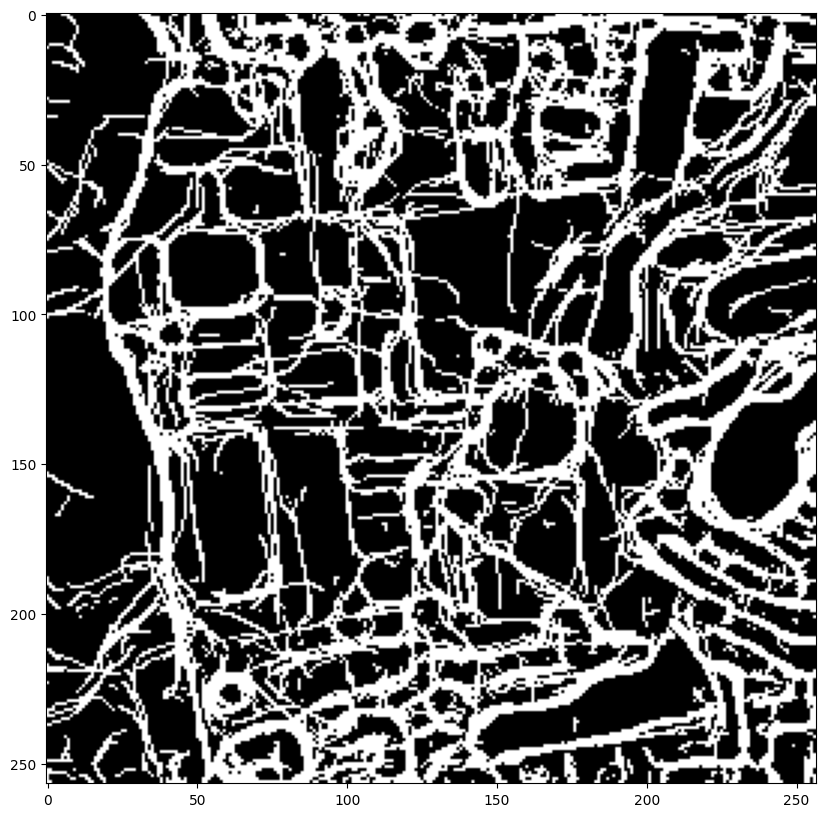

In [41]:
""" NUMPY VISUALISATION detection for RGB"""

longitude = 54.6014 # y
latitude = 18.090 # x
point = ee.Geometry.Point([latitude, longitude])
time_periods = [['2019-06-01', '2019-09-01'], ['2020-06-01', '2020-09-01'], ['2021-06-01', '2021-09-01'], ['2022-06-01', '2022-09-01'], ['2023-06-01', '2023-09-01'], ['2024-06-01', '2024-09-01']]

edgeDetector = EdgeDetector(time_periods, [point])
map = edgeDetector.detect_and_return_merged_bands(['B4', 'B3', 'B2'], [110 if i % 2 == 0 else 120 for i in range(6)], [5, 11, 4], 5)

import matplotlib.pyplot as plt

areaDetector = AreaDetector(map)
img_array = areaDetector.move_rectangle_to_numpy(point)

fig, axs = plt.subplots(figsize=(10, 10))

# Plot Image in an RGB Composite
axs.imshow(img_array, cmap='gray', vmin=0, vmax=1)
plt.show()

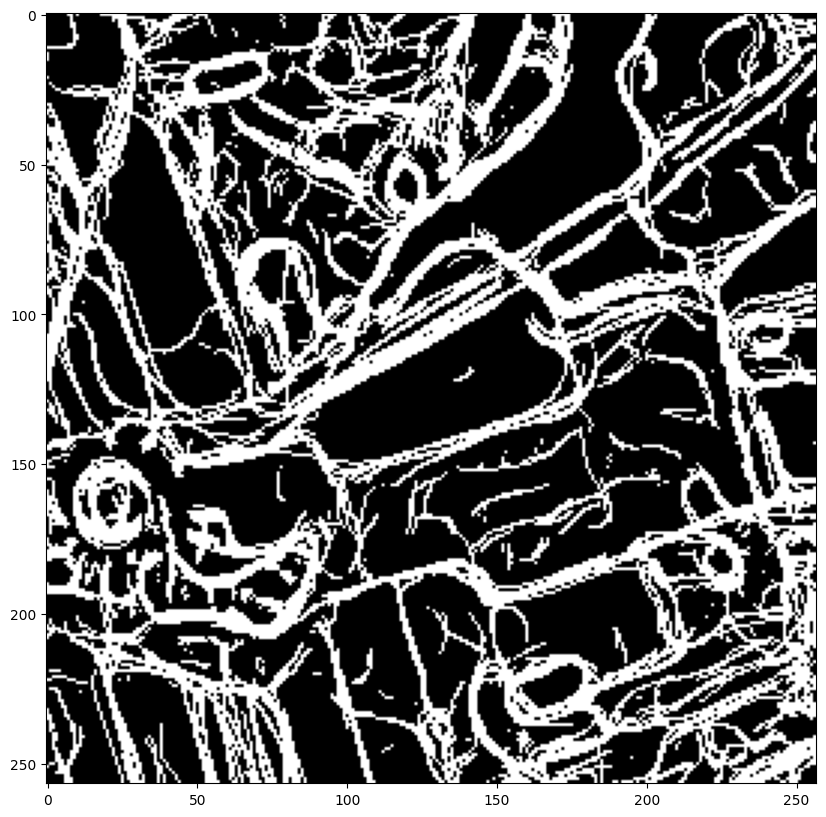

In [42]:
longitude = 53.325556
latitude = 18.443333
point = ee.Geometry.Point([latitude, longitude])
time_periods = [['2019-06-01', '2019-09-01'], ['2020-06-01', '2020-09-01'], ['2021-06-01', '2021-09-01'], ['2022-06-01', '2022-09-01'], ['2023-06-01', '2023-09-01'], ['2024-06-01', '2024-09-01']]

detector = EdgeDetector(time_periods, [point])
map = detector.detect_and_return_merged_bands(['B4', 'B3', 'B2'], [110 if i % 2 == 0 else 120 for i in range(6)], [5, 11, 4], 5)

import matplotlib.pyplot as plt

areaDetector = AreaDetector(map)
img_array = areaDetector.move_rectangle_to_numpy(point)

fig, axs = plt.subplots(figsize=(10, 10))

# Plot Image in an RGB Composite
axs.imshow(img_array, cmap='gray', vmin=0, vmax=1)
plt.show()

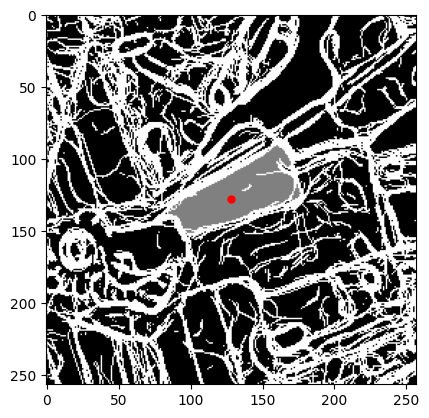

In [52]:
""" Single area detection """

longitude = 53.325556
latitude = 18.443333
point = ee.Geometry.Point([latitude, longitude])
time_periods = [['2017-06-01', '2017-09-01'], ['2018-06-01', '2018-09-01'], ['2019-06-01', '2019-09-01'], ['2020-06-01', '2020-09-01'], ['2021-06-01', '2021-09-01'], ['2022-06-01', '2022-09-01'], ['2023-06-01', '2023-09-01'], ['2024-06-01', '2024-09-01']]

detector = EdgeDetector(time_periods, [point])
map = detector.detect_and_return_merged_bands(['B4', 'B3', 'B2'], [110 if i % 2 == 0 else 120 for i in range(6)], [5, 11, 4], 5)

import matplotlib.pyplot as plt

areaDetector = AreaDetector(map)
img_array = areaDetector.detect_in_point(point)

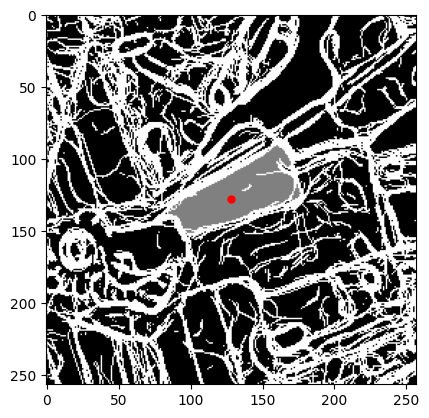

In [51]:
""" Single area detection """

longitude = 53.325556
latitude = 18.443333
point = ee.Geometry.Point([18.445007, 53.325876])
time_periods = [['2017-06-01', '2017-09-01'], ['2018-06-01', '2018-09-01'], ['2019-06-01', '2019-09-01'], ['2020-06-01', '2020-09-01'], ['2021-06-01', '2021-09-01'], ['2022-06-01', '2022-09-01'], ['2023-06-01', '2023-09-01'], ['2024-06-01', '2024-09-01']]

detector = EdgeDetector(time_periods, [point])
map = detector.detect_and_return_merged_bands(['B4', 'B3', 'B2'], [110 if i % 2 == 0 else 120 for i in range(6)], [5, 11, 4], 5)

import matplotlib.pyplot as plt

areaDetector = AreaDetector(map)
img_array = areaDetector.detect_in_point(point)